In [1]:
import numpy as np
import pandas as pd
import scipy
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# GD Optimization

## GD functions definition

#### basic gradient descent

In [2]:
def GD(f, grad_f, x0, alpha, maxit=1000, tolf=1e-6, tolx=1e-6):
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))

    f_val[0] = f(x0)
    grad_norm[0] = np.linalg.norm(grad_f(x0), 2) 

    for k in range(maxit):
        x = x0 - alpha * grad_f(x0)

        f_val[k+1]=f(x)
        grad_norm[k+1]=np.linalg.norm(grad_f(x), 2)

        if np.linalg.norm(grad_f(x), 2) < tolf*grad_norm[0] or np.linalg.norm(x-x0, 2)<tolx:
            break

        x0 = x

    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]

    return x, k, f_val, grad_norm

#### gradient descent with backtraking to find the step length 

In [3]:
def backtracking(f, grad_f, x):
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x)) > f(x) - c * alpha * np.linalg.norm(grad_f(x), 2) ** 2:
        alpha = tau * alpha
    return alpha


def GD_backtracking(f, grad_f, x0, maxit=1000, tolf=1e-6, tolx=1e-6):
    assert callable(f)
    assert callable(grad_f)
    assert isinstance(maxit, int)

    k = 0

    f_val = np.zeros(maxit+1, )
    grad_norm = np.zeros(maxit+1, )

    f_val[0] = f(x0)
    grad_norm[0] = np.linalg.norm(grad_f(x0))

    while k < maxit:
        alpha = backtracking(f, grad_f, x0)
        x = x0 - alpha * grad_f(x0)

        f_val[k+1] = f(x)
        grad_norm[k+1] = np.linalg.norm(grad_f(x0))

        if np.linalg.norm(x0-x) < tolx or np.linalg.norm(grad_f(x)) <= tolf*grad_norm[0]:
            break
        x0 = x
        k += 1

    return x, k, f_val[:k], grad_norm[:k]

#### GD with history

In [4]:
def GD_history(f, grad_f, x0, alpha, maxit=1000, tolf=1e-6, tolx=1e-6):
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))
    xs = np.zeros((maxit+1, x0.shape[0]))

    f_val[0] = f(x0)
    grad_norm[0] = np.linalg.norm(grad_f(x0), 2) 
    xs[0, :] = x0

    for k in range(maxit):
        x = x0 - alpha * grad_f(x0)

        xs[k+1, :] = x
        f_val[k+1]=f(x)
        grad_norm[k+1]=np.linalg.norm(grad_f(x), 2)

        if np.linalg.norm(grad_f(x), 2) < tolf*grad_norm[0] or np.linalg.norm(x-x0, 2)<tolx:
            break

        x0 = x

    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]
    xs = xs[:k+1, :]

    return x, k, f_val, grad_norm, xs


def next_step(f, grad, x): # backtracking procedure for the choice of the steplength
    alpha=1.1
    rho = 0.5
    c1 = 0.25
    p=-grad
    j=0
    jmax=10
    while f(x + alpha*p) > (f(x) + c1*alpha*(grad.T @ p)) and j < jmax:
        alpha = rho*alpha
        j += 1
    if j >= jmax:
        return -1
    else:
        return alpha

def GD_backtracking_history(f, grad_f, x0, maxit=1000, tolf=1e-6, tolx=1e-6):
    f_val = np.zeros((maxit+1,))
    grad_norm = np.zeros((maxit+1,))
    xs = np.zeros((maxit+1, x0.shape[0]))

    f_val[0] = f(x0)
    grad_norm[0] = np.linalg.norm(grad_f(x0), 2) 
    xs[0, :] = x0

    for k in range(maxit):
        alpha = next_step(f, grad_f(x0), x0)
        x = x0 - alpha * grad_f(x0)

        xs[k+1, :] = x
        f_val[k+1]=f(x)
        grad_norm[k+1]=np.linalg.norm(grad_f(x), 2)

        if np.linalg.norm(grad_f(x), 2) < tolf*grad_norm[0] or np.linalg.norm(x-x0, 2)<tolx:
            break

        x0 = x

    f_val = f_val[:k+1]
    grad_norm = grad_norm[:k+1]
    xs = xs[:k+1, :]


    return x, k, f_val, grad_norm, xs



## tests with 5 functions

#### functions definition

In [48]:
def f1(x):
    return (x[0]-3)**2 + (x[1]-1)**2

def f2(x):
    return 10*(x[0]-1)**2 + (x[1]-2)**2

def f3(x):
    n = x.shape[0]        
    v = np.linspace(0, 1, n)
    A = np.vander(v, n)
    xs = np.ones((n,))
    b = A @ xs
    return (1/2) * np.linalg.norm(((A@x) - b), 2)**2

def f4(x):
    n = x.shape[0]        
    v = np.linspace(0, 1, n)
    A = np.vander(v, n)
    xs = np.ones((n,))
    b = A @ xs
    return ((1/2) * np.linalg.norm(((A@x) - b), 2)**2) + ((l/2) *  np.linalg.norm(x, 2)**2)

def f5(x):
    return x[0]**4 + x[0]**3 - 2*(x[0]**2) - 2*x[0]

# derivatives
def d1(x):
    return np.array([2*(x[0]-3), 2*(x[1]-1)])

def d2(x):
    return np.array([20*(x[0]-1), 2*(x[1]-2)])

def d3(x):
    n = x.shape[0]
    v = np.linspace(0, 1, n)
    A = np.vander(v, n)
    xs = np.ones((n,))
    b = A @ xs
    return A.T @ (A @ x - b)

def d4(x):
    n = x.shape[0]
    v = np.linspace(0, 1, n)
    A = np.vander(v, n)
    xs = np.ones((n,))
    b = A @ xs
    return A.T @ (A @ x - b) + l * x

def d5(x):
    return np.array([4*x[0]**3 + 3*x[0]**2 - 4*x[0] -2])

#### function #1

relative errors:
relative error of GD with alpha=0.1:  	0.000016
relative error of GD with alpha=0.01:  	0.187552
relative error of GD with alpha=0.001: 	1.157628
relative error of GD with backtracking:	0.000028


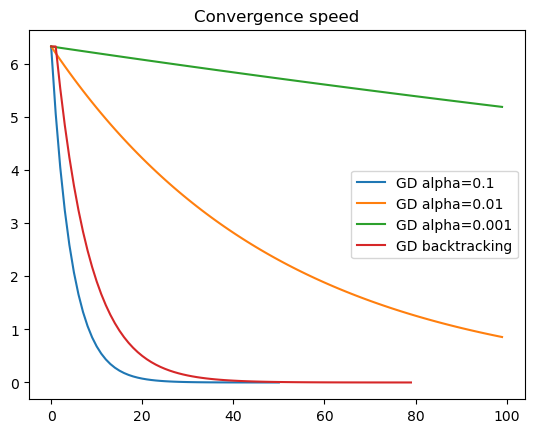

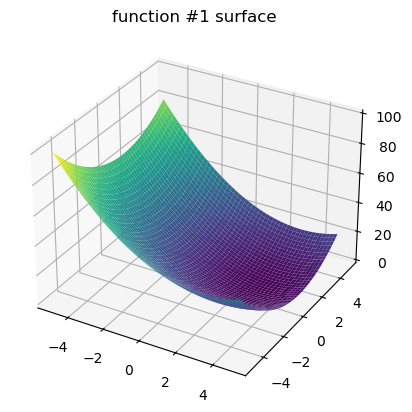

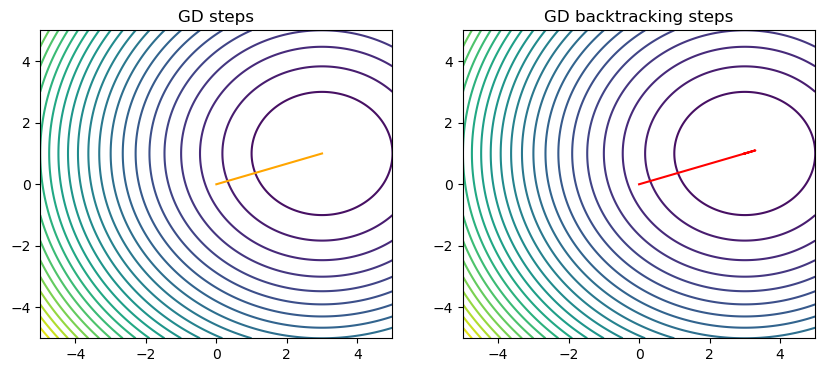

In [ ]:
x0 = np.zeros((2))
alpha = 0.01
kmax = 100
tolf = tolx = 1e-5
x1_true = np.array([3,1])

x1_GDa1, k_GDa1, f_val, grad_norm_GDa1 = GD(f1, d1, x0, 0.1, kmax, tolf, tolx)
x1_GDa01, k_GDa01, f_val, grad_norm_GDa01 = GD(f1, d1, x0, alpha, kmax, tolf, tolx)
x1_GDa001, k_GDa001, f_val, grad_norm_GDa001 = GD(f1, d1, x0, 0.001, kmax, tolf, tolx)
x1_GDB, k_GDB, f_val, grad_norm_GDB = GD_backtracking(f1, d1, x0, kmax, tolf, tolx)

error1_GDa1 = np.linalg.norm((x1_true-x1_GDa1)/x1_true)
error1_GDa01 = np.linalg.norm((x1_true-x1_GDa01)/x1_true)
error1_GDa001 = np.linalg.norm((x1_true-x1_GDa001)/x1_true)
error1_GDB = np.linalg.norm((x1_true-x1_GDB)/x1_true)

print("relative errors:")
print(f"relative error of GD with alpha=0.1:  \t{error1_GDa1:.6f}")
print(f"relative error of GD with alpha=0.01:  \t{error1_GDa01:.6f}")
print(f"relative error of GD with alpha=0.001: \t{error1_GDa001:.6f}")
print(f"relative error of GD with backtracking:\t{error1_GDB:.6f}")

# convergence speed plot
plt.plot(range(k_GDa1+1), grad_norm_GDa1, label="GD alpha=0.1")
plt.plot(range(k_GDa01+1), grad_norm_GDa01, label="GD alpha=0.01")
plt.plot(range(k_GDa001+1), grad_norm_GDa001, label="GD alpha=0.001")
plt.plot(range(k_GDB), grad_norm_GDB, label="GD backtracking")
plt.title("Convergence speed")
plt.legend()
plt.show()

"""
    the convergence with alpha=0.01 happens for k > 200, with alpha=0.001 for k > 2000 
"""

x1_GD, k, f_val, grad_norm, xs = GD_history(f1, d1, x0, 0.05, kmax, tolf, tolx)
x1_GD, k, f_val, grad_norm, xsB = GD_backtracking_history(f1, d1, x0, kmax, tolf, tolx)

# 3d plots
x = np.linspace(-5,5,500) # (1,2.5,100)
y = np.linspace(-5,5,500) # (0,1.5,100)
X,Y = np.meshgrid(x,y)
Z = f1([X,Y])

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('function #1 surface')
plt.show()

plt.figure(figsize=(10, 4))
plt1 = plt.subplot(1,2,1)
plt1 = plt.contour(X, Y, Z, levels=30)
plt1 = plt.plot(xs[:, 0],xs[:, 1], c="orange")
plt1 = plt.title('GD steps')

plt2 = plt.subplot(1,2,2)
plt2 = plt.contour(X, Y, Z, levels=30)
plt2 = plt.plot(xsB[:, 0],xsB[:, 1], c="red")
plt2 = plt.title('GD backtracking steps')

plt.show()

#### function #2

relative errors:
relative error of GD with alpha=0.1:  	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


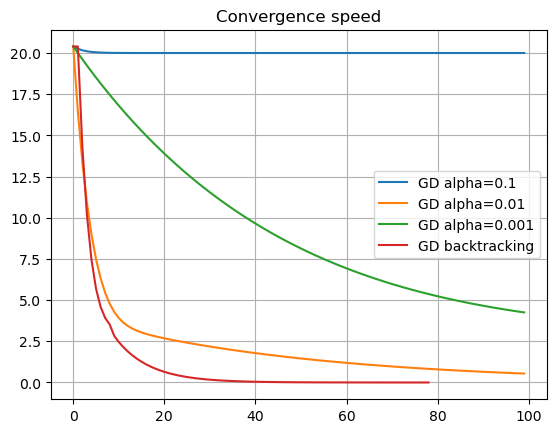

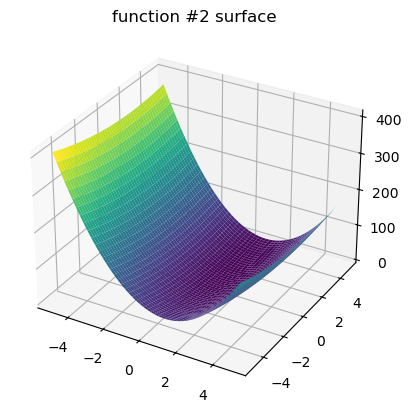

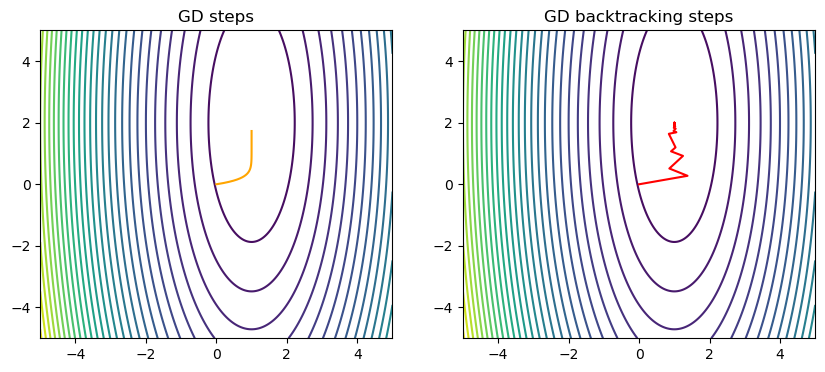

In [ ]:
""" function #2 """

x0 = np.zeros((2))
alpha = 0.01
kmax = 100
tolf = tolx = 1e-5
x2_true = np.array([1,2])

x2_GDa1, k_GDa1, f_val, grad_norm_GDa1 = GD(f2, d2, x0, 0.1, kmax, tolf, tolx)
x2_GDa01, k_GDa01, f_val, grad_norm_GDa01 = GD(f2, d2, x0, alpha, kmax, tolf, tolx)
x2_GDa001, k_GDa001, f_val, grad_norm_GDa001 = GD(f2, d2, x0, 0.001, kmax, tolf, tolx)
x2_GDB, k_GDB, f_val, grad_norm_GDB = GD_backtracking(f2, d2, x0, kmax, tolf, tolx)

error2_GDa1 = np.linalg.norm((x2_true-x2_GDa1)/x2_true)
error2_GDa01 = np.linalg.norm((x2_true-x2_GDa01)/x2_true)
error2_GDa001 = np.linalg.norm((x2_true-x2_GDa001)/x2_true)
error2_GDB = np.linalg.norm((x2_true-x2_GDB)/x2_true)

print("relative errors:")
print(f"relative error of GD with alpha=0.1:  \t{error2_GDa1:.6f}")
print(f"relative error of GD with alpha=0.01:  \t{error2_GDa01:.6f}")
print(f"relative error of GD with alpha=0.001: \t{error2_GDa001:.6f}")
print(f"relative error of GD with backtracking:\t{error2_GDB:.6f}")

# convergence speed plot
plt.plot(range(k_GDa1+1), grad_norm_GDa1, label="GD alpha=0.1")
plt.plot(range(k_GDa01+1), grad_norm_GDa01, label="GD alpha=0.01")
plt.plot(range(k_GDa001+1), grad_norm_GDa001, label="GD alpha=0.001")
plt.plot(range(k_GDB), grad_norm_GDB, label="GD backtracking")
plt.title("Convergence speed")
plt.legend()
plt.grid()
plt.show()

"""
    with alpha=0.1 the GD soes not converge, with alpha=0.01 for k > 400, with alpha=0.01 for k > 1500
"""

x2_GD, k, f_val, grad_norm, xs = GD_history(f2, d2, x0, alpha, kmax, tolf, tolx)
x2_GDB, k, f_val, grad_norm, xsB = GD_backtracking_history(f2, d2, x0, kmax, tolf, tolx)
# 3d plots
x = np.linspace(-5,5,500) # (1,2.5,100)
y = np.linspace(-5,5,500) # (0,1.5,100)
X,Y = np.meshgrid(x,y)
Z = f2([X,Y])

ax = plt.axes(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_title('function #2 surface')
plt.show()

plt.figure(figsize=(10, 4))
plt1 = plt.subplot(1,2,1)
plt1 = plt.contour(X, Y, Z, levels=30)
plt1 = plt.plot(xs[:, 0],xs[:, 1], c="orange")
plt1 = plt.title('GD steps')

plt2 = plt.subplot(1,2,2)
plt2 = plt.contour(X, Y, Z, levels=30)
plt2 = plt.plot(xsB[:, 0],xsB[:, 1], c="red")
plt2 = plt.title('GD backtracking steps')

plt.show()

#### function #3

For n = 5
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


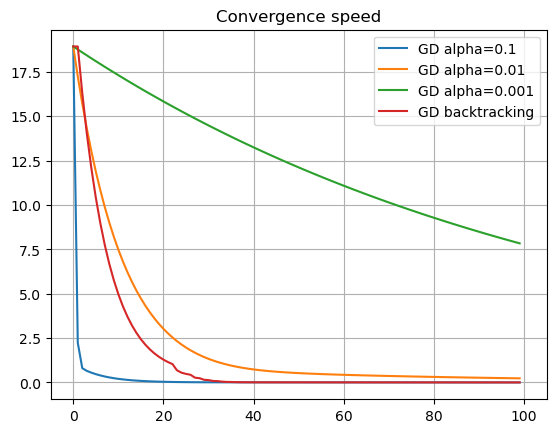

For n = 10
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


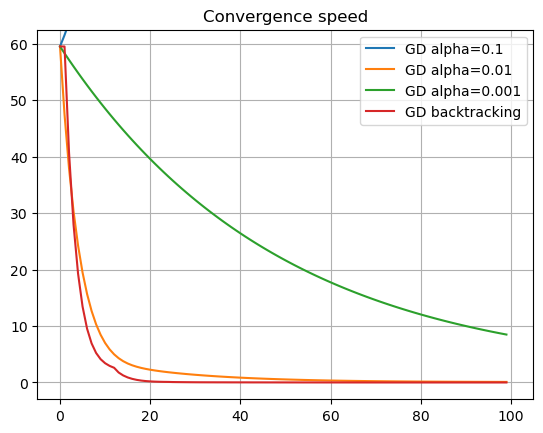

For n = 15
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


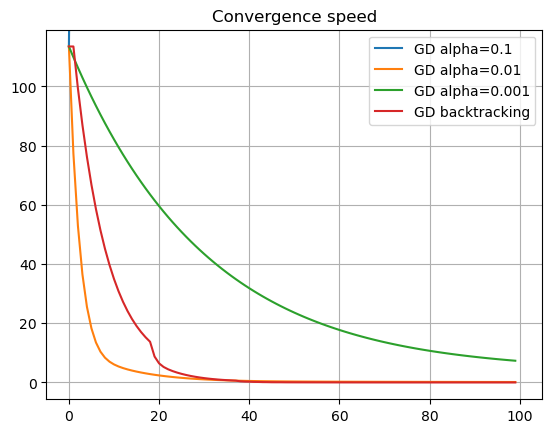

For n = 20
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


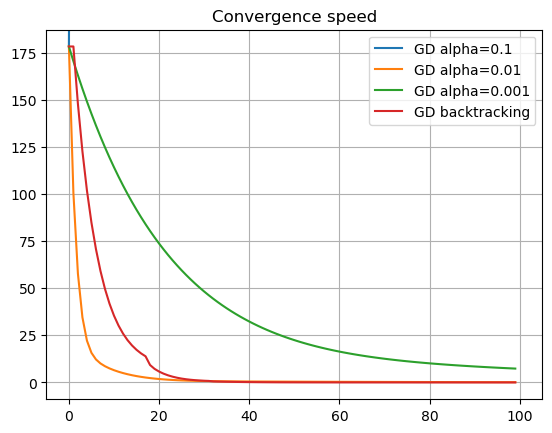

In [234]:
alpha = 0.01
kmax = 100
tolf = tolx = 1e-5

for n in range(5, 25, 5):
    x0 = np.zeros((n))
    x3_true = np.ones(n)

    x3_GDa1, k_GDa1, f_val, grad_norm_GDa1 = GD(f3, d3, x0, 0.1, kmax, tolf, tolx)
    x3_GDa01, k_GDa01, f_val, grad_norm_GDa01 = GD(f3, d3, x0, alpha, kmax, tolf, tolx)
    x3_GDa001, k_GDa001, f_val, grad_norm_GDa001 = GD(f3, d3, x0, 0.001, kmax, tolf, tolx)
    x3_GDB, k_GDB, f_val, grad_norm_GDB = GD_backtracking(f3, d3, x0, kmax, tolf, tolx)

    error3_GDa1 = np.linalg.norm((x3_true-x3_GDa1)/x3_true)
    error3_GDa01 = np.linalg.norm((x3_true-x3_GDa01)/x3_true)
    error3_GDa001 = np.linalg.norm((x3_true-x3_GDa001)/x3_true)
    error3_GDB = np.linalg.norm((x3_true-x3_GDB)/x3_true)

    print(f"For n = {n}")
    print("relative errors:")
    print(f"relative error of GD with alpha=0.1:   \t{error2_GDa1:.6f}")
    print(f"relative error of GD with alpha=0.01:  \t{error2_GDa01:.6f}")
    print(f"relative error of GD with alpha=0.001: \t{error2_GDa001:.6f}")
    print(f"relative error of GD with backtracking:\t{error2_GDB:.6f}")

    # convergence speed plots
    plt.plot(range(k_GDa1+1), grad_norm_GDa1, label="GD alpha=0.1")
    plt.plot(range(k_GDa01+1), grad_norm_GDa01, label="GD alpha=0.01")
    plt.plot(range(k_GDa001+1), grad_norm_GDa001, label="GD alpha=0.001")
    plt.plot(range(k_GDB), grad_norm_GDB, label="GD backtracking")
    plt.title("Convergence speed")
    plt.legend()
    plt.grid()
    plt.axis([-5, 105, -(1/20*max(grad_norm_GDa01)), max(grad_norm_GDa01)+(1/20*max(grad_norm_GDa01))])
    plt.show()


#### function #4

For lambda = 0.0
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


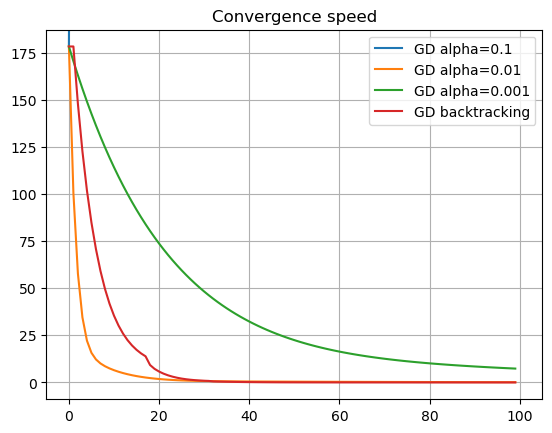

For lambda = 0.25
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


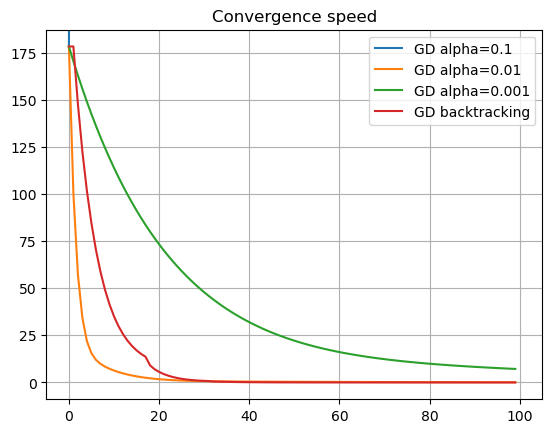

For lambda = 0.5
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


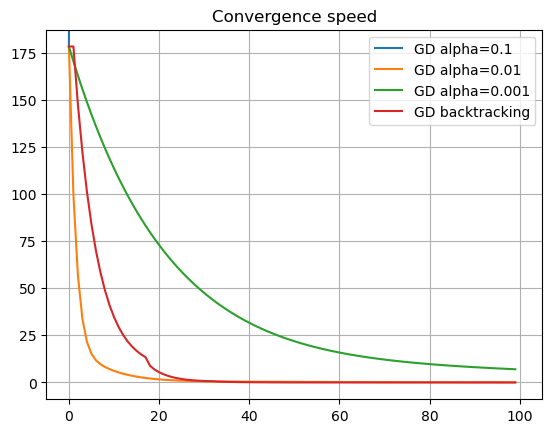

For lambda = 0.75
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


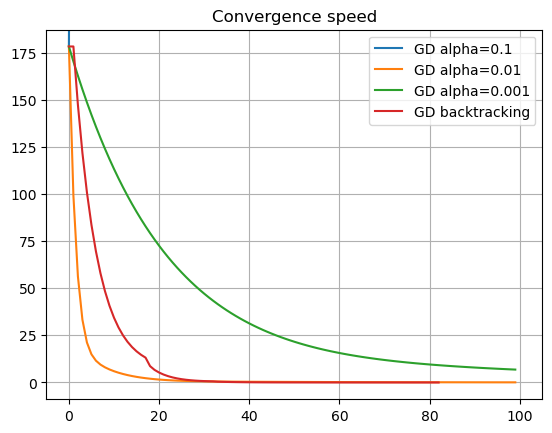

For lambda = 1.0
relative errors:
relative error of GD with alpha=0.1:   	1.000000
relative error of GD with alpha=0.01:  	0.132620
relative error of GD with alpha=0.001: 	0.829240
relative error of GD with backtracking:	0.000047


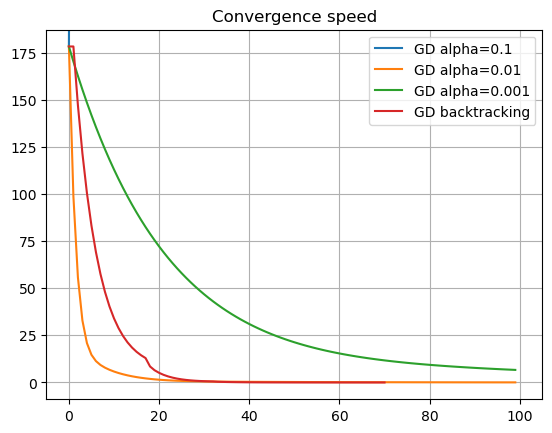

In [235]:
alpha = 0.01
kmax = 100
tolf = tolx = 1e-5

for l in np.linspace(0, 1, 5):
    x0 = np.zeros((n))
    x4_true = np.ones(n)

    x4_GDa1, k_GDa1, f_val, grad_norm_GDa1 = GD(f4, d4, x0, 0.1, kmax, tolf, tolx)
    x4_GDa01, k_GDa01, f_val, grad_norm_GDa01 = GD(f4, d4, x0, alpha, kmax, tolf, tolx)
    x4_GDa001, k_GDa001, f_val, grad_norm_GDa001 = GD(f4, d4, x0, 0.001, kmax, tolf, tolx)
    x4_GDB, k_GDB, f_val, grad_norm_GDB = GD_backtracking(f4, d4, x0, kmax, tolf, tolx)

    error4_GDa1 = np.linalg.norm((x4_true-x4_GDa1)/x4_true)
    error4_GDa01 = np.linalg.norm((x4_true-x4_GDa01)/x4_true)
    error4_GDa001 = np.linalg.norm((x4_true-x4_GDa001)/x4_true)
    error4_GDB = np.linalg.norm((x4_true-x4_GDB)/x4_true)

    print(f"For lambda = {l}")
    print("relative errors:")
    print(f"relative error of GD with alpha=0.1:   \t{error2_GDa1:.6f}")
    print(f"relative error of GD with alpha=0.01:  \t{error2_GDa01:.6f}")
    print(f"relative error of GD with alpha=0.001: \t{error2_GDa001:.6f}")
    print(f"relative error of GD with backtracking:\t{error2_GDB:.6f}")

    # convergence speed plots
    plt.plot(range(k_GDa1+1), grad_norm_GDa1, label="GD alpha=0.1")
    plt.plot(range(k_GDa01+1), grad_norm_GDa01, label="GD alpha=0.01")
    plt.plot(range(k_GDa001+1), grad_norm_GDa001, label="GD alpha=0.001")
    plt.plot(range(k_GDB), grad_norm_GDB, label="GD backtracking")
    plt.title("Convergence speed")
    plt.legend()
    plt.grid()
    plt.axis([-5, 105, -(1/20*max(grad_norm_GDa01)), max(grad_norm_GDa01)+(1/20*max(grad_norm_GDa01))])
    plt.show()


#### function #5

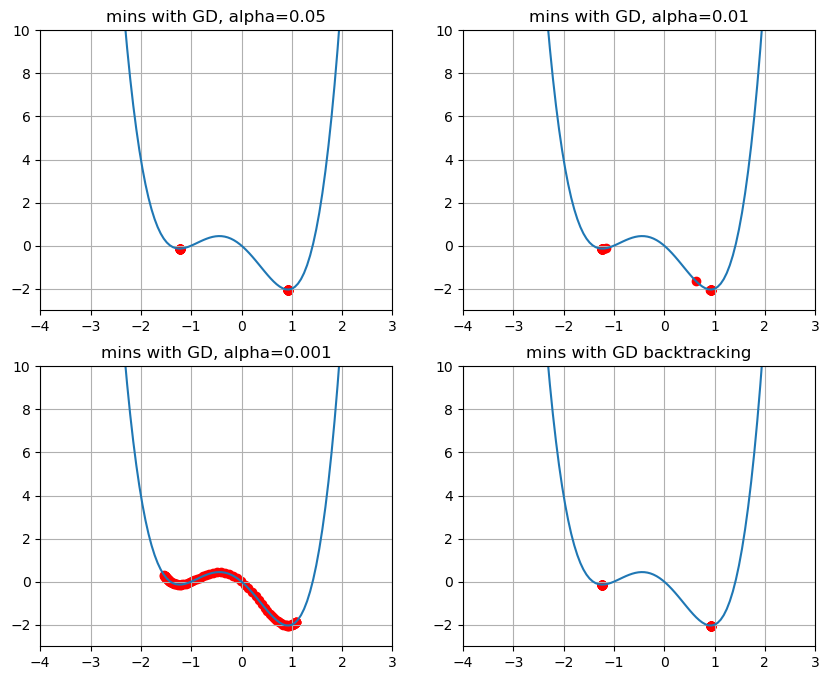

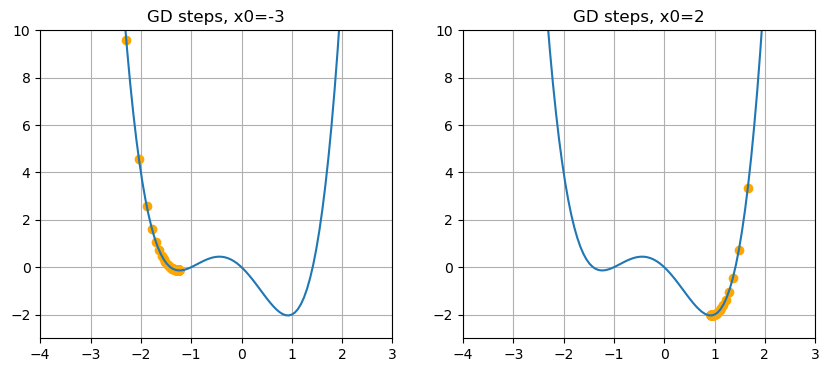

In [ ]:
alpha = 0.01
kmax = 100
tolf = tolx = 1e-5
minsGDa05 = []
minsGDa01 = []
minsGDa001 = []
minsGDB = []

for x0 in np.linspace(-3, 2, 100):
    x5_GDa05, k, f_val, grad_norm = GD(f5, d5, [x0], 0.05, kmax, tolf, tolx)
    x5_GDa01, k, f_val, grad_norm = GD(f5, d5, [x0], alpha, kmax, tolf, tolx)
    x5_GDa001, k, f_val, grad_norm = GD(f5, d5, [x0], 0.001, kmax, tolf, tolx)
    x5_GDB, k, f_val, grad_norm = GD_backtracking(f5, d5, [x0], kmax, tolf, tolx)

    minsGDa05.append(x5_GDa05)
    minsGDa01.append(x5_GDa01)
    minsGDa001.append(x5_GDa001)
    minsGDB.append(x5_GDB)

# plot the result
X = np.linspace(-3, 3, 100)
Y = [f5([x]) for x in X]

# GD mins
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD, alpha=0.05")
plt.plot(X, Y)
plt.scatter(minsGDa05, [f5([x]) for x in minsGDa05], c="red")

plt.subplot(2, 2, 2)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD, alpha=0.01")
plt.plot(X, Y)
plt.scatter(minsGDa01, [f5([x]) for x in minsGDa01], c="red")

plt.subplot(2, 2, 3)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD, alpha=0.001")
plt.plot(X, Y)
plt.scatter(minsGDa001, [f5([x]) for x in minsGDa001], c="red")

plt.subplot(2, 2, 4)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD backtracking")
plt.plot(X, Y)
plt.scatter(minsGDB, [f5([x]) for x in minsGDB], c="red")

plt.show()

# GD steps
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
x5_GDB, k, f_val, grad_norm, xs = GD_history(f5, d5, np.array([-3]), 0.01, kmax, tolf, tolx)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("GD steps, x0=-3")
plt.plot(X, Y)
plt.scatter(xs, [f5(np.array(x)) for x in xs], c="orange")

plt.subplot(1, 2, 2)
x5_GDB, k, f_val, grad_norm, xs = GD_history(f5, d5, np.array([2]), 0.01, kmax, tolf, tolx)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("GD steps, x0=2")
plt.plot(X, Y)
plt.scatter(xs, [f5(np.array(x)) for x in xs], c="orange")

plt.show()


convergence speed

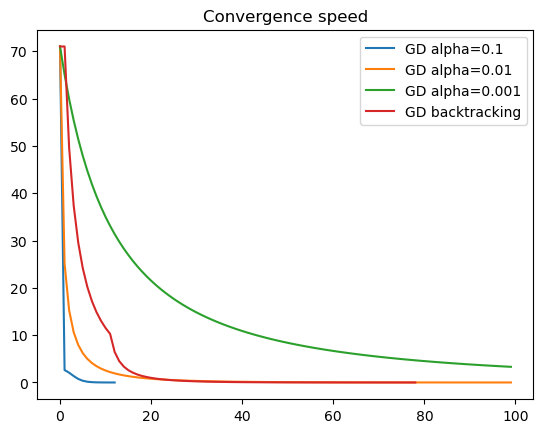

In [ ]:
alpha = 0.01
kmax = 100
tolf = tolx = 1e-5
n_x0s = 100

x5 = np.zeros((n_x0s, 4))
k = np.zeros((n_x0s, 4))
grad_norm = np.zeros((n_x0s, 4, kmax))

i = 0
for x0 in np.linspace(-3, 2, n_x0s):
    a, b, c, d = GD(f5, d5, [x0], 0.05, kmax, tolf, tolx)
    x5[i, 0], k[i, 0], f_val, grad_norm[i, 0, :b+1] = a, b+1, c ,d
    a, b, c, d = GD(f5, d5, [x0], alpha, kmax, tolf, tolx)
    x5[i, 1], k[i, 1], f_val, grad_norm[i, 1, :b+1] = a, b+1, c ,d
    a, b, c, d = GD(f5, d5, [x0], 0.001, kmax, tolf, tolx)
    x5[i, 2], k[i, 2], f_val, grad_norm[i, 2, :b+1] = a, b+1, c ,d
    a, b, c, d = GD_backtracking(f5, d5, [x0], kmax, tolf, tolx)
    x5[i, 3], k[i, 3], f_val, grad_norm[i, 3, :b] = a, b, c ,d

    i += 1

plt.plot(range(int(k[0, 0])), grad_norm[0, 0, :int(k[0, 0])], label="GD alpha=0.1")
plt.plot(range(int(k[0, 1])), grad_norm[0, 1, :int(k[0, 1])], label="GD alpha=0.01")
plt.plot(range(int(k[0, 2])), grad_norm[0, 2, :int(k[0, 2])], label="GD alpha=0.001")
plt.plot(range(int(k[0, 3])), grad_norm[0, 3, :int(k[0, 3])], label="GD backtracking")
plt.title("Convergence speed")
plt.legend()
plt.show()

GD mins

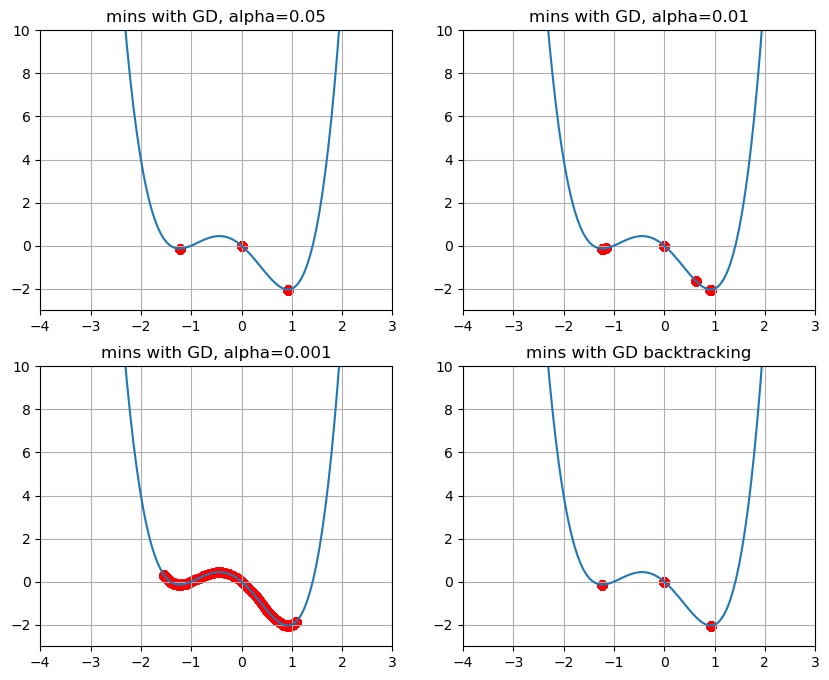

In [ ]:
X = np.linspace(-3, 3, 100)
Y = [f5([x]) for x in X]

plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD, alpha=0.05")
plt.plot(X, Y)
plt.scatter(x5[:, 0], [f5([x]) for x in x5[:, 0]], c="red")

plt.subplot(2, 2, 2)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD, alpha=0.01")
plt.plot(X, Y)
plt.scatter(x5[:, 1], [f5([x]) for x in x5[:, 1]], c="red")

plt.subplot(2, 2, 3)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD, alpha=0.001")
plt.plot(X, Y)
plt.scatter(x5[:, 2], [f5([x]) for x in x5[:, 2]], c="red")

plt.subplot(2, 2, 4)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("mins with GD backtracking")
plt.plot(X, Y)
plt.scatter(x5[:, 3], [f5([x]) for x in x5[:, 3]], c="red")

plt.show()


GD steps

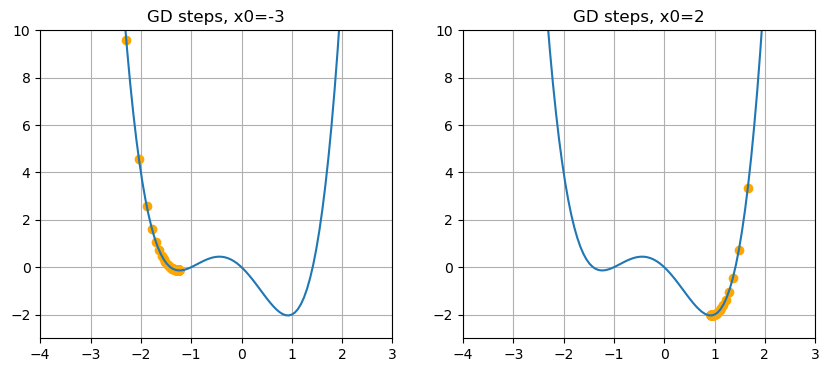

In [224]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
x5_GDB, k, f_val, grad_norm, xs = GD_history(f5, d5, np.array([-3]), alpha, kmax, tolf, tolx)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("GD steps, x0=-3")
plt.plot(X, Y)
plt.scatter(xs, [f5(np.array(x)) for x in xs], c="orange")

plt.subplot(1, 2, 2)
x5_GDB, k, f_val, grad_norm, xs = GD_history(f5, d5, np.array([2]), alpha, kmax, tolf, tolx)
plt.axis([-4, 3, -3, 10])
plt.grid()
plt.title("GD steps, x0=2")
plt.plot(X, Y)
plt.scatter(xs, [f5(np.array(x)) for x in xs], c="orange")

plt.show()

# SGD Optimization

### Optimization functions

In [ ]:
def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling

    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            gradient = grad_loss(theta, X_batch, y_batch)
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

In [ ]:
def GD(loss, grad_loss, D, theta0, alpha, n_epochs):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling

    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Compute the gradient of the loss
        gradient = grad_loss(theta, X, y)
        grad_norm_history[epoch] = np.linalg.norm(gradient, 2)

        # Update weights
        theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
    
    return theta_history, loss_history, grad_norm_history

In [7]:
def backtracking(f, grad_f, theta, x, y):
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(theta, x, y), x, y) > f(theta, x, y) - c * alpha * np.linalg.norm(grad_f(theta, x, y), 2) ** 2:
        alpha = tau * alpha
        print(alpha)
    return alpha

def GD_backtracking(loss, grad_loss, D, theta0, n_epochs):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling

    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Compute the gradient of the loss
        gradient = grad_loss(theta, X, y)
        grad_norm_history[epoch] = np.linalg.norm(gradient, 2)

        # Update weights
        alpha = backtracking(loss, grad_loss, theta, X, y)
        theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        loss_history[epoch] = loss(theta, X, y)
    
    return theta_history, loss_history, grad_norm_history

## Tests

### K = 5, Theta* = [0,0,4,0,-3]

In [90]:
batch_size = 8
n_epochs = 100
K = 5
theta0 = np.zeros((K,))
alpha = 0.1

f = lambda x, p: sum([x**i*p[i] for i in range(len(p))])

def loss(theta, X, y):
    y_pred = f(X, theta)
    error = np.square(y_pred - y)
    return np.mean(error)

def grad_loss(theta, X, y):
    N = len(y)
    y_pred = f(X, theta)  # Polynomial predictions
    error = y_pred - y
    
    # Compute the gradient of the squared error loss w.r.t. each parameter in theta
    gradient = np.zeros_like(theta)
    for i in range(len(theta)):  # Each parameter in theta
        gradient[i] = 2 * np.sum(error * (X ** i)) / N
    
    return gradient

#### Large dataset

##### Training with SGD

Theta: [-0.03094695  0.46608084  3.03855181  0.54086725 -2.91848423]
Relative error: 0.011153857365891882


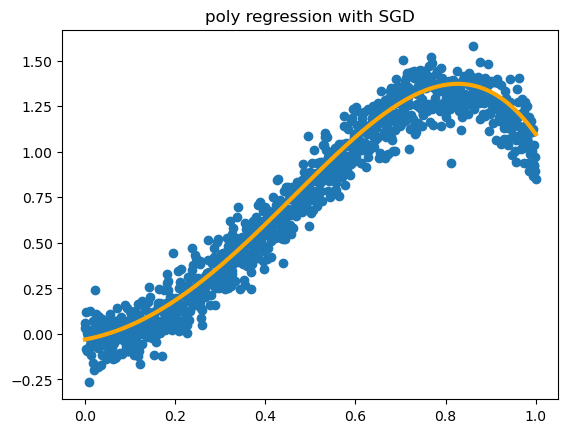

In [89]:
# Load data
data_large = pd.read_csv("../data/poly_regression_large.csv")
X_large, Y_large = data_large["x"], data_large["y"]
X_train_large, X_test_large, Y_train_large, Y_test_large = train_test_split(X_large, Y_large, test_size=0.20, random_state=333, shuffle=True)
X_train_large, X_test_large, Y_train_large, Y_test_large = np.array(X_train_large), np.array(X_test_large), np.array(Y_train_large), np.array(Y_test_large)

assert X_train_large.shape[0], Y_train_large.shape[0]

# Train
theta_history, loss_history, grad_norm_history = SGD(loss, grad_loss, (X_train_large, Y_train_large), theta0, alpha, batch_size, n_epochs)
err_SGD = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
theta_SGD = theta_history[-1]

# Results
print(f"Theta: {theta_history[-1]}")
print(f"Relative error: {err_SGD}")

plt.scatter(X_large, Y_large)
plt.plot(X_large, f(X_large, theta_history[-1]), c="orange", linewidth=3)
plt.title("poly regression with SGD")
plt.show()

##### Training with GD

Theta: [0.17306214 0.69697462 0.45490828 0.22572888 0.06364564]
Relative error: 0.06400254378444284


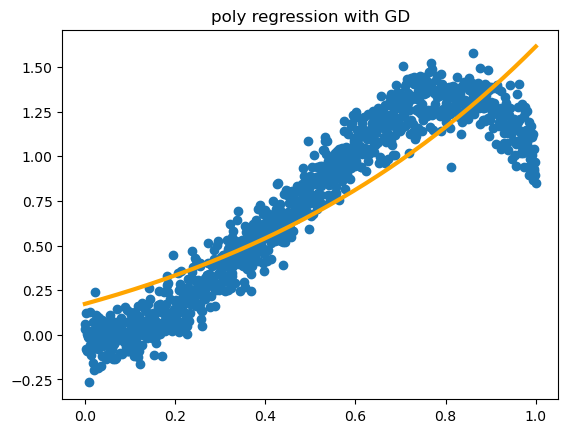

In [79]:
# Train
theta_history, loss_history, grad_norm_history = GD(loss, grad_loss, (X_train_large, Y_train_large), theta0, alpha, n_epochs)
err_GD = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
theta_GD = theta_history[-1]

# Results
print(f"Theta: {theta_history[-1]}")
print(f"Relative error: {err_GD}")

plt.scatter(X_large, Y_large)
plt.plot(X_large, f(X_large, theta_history[-1]), c="orange", linewidth=3)
plt.title("poly regression with GD")
plt.show()

#### Small dataset

##### Training with normal equations

Theta: [ 0.03290773 -0.45977277  4.84291477  0.1721476  -3.66058933]
Relative error: 0.01080056221986107


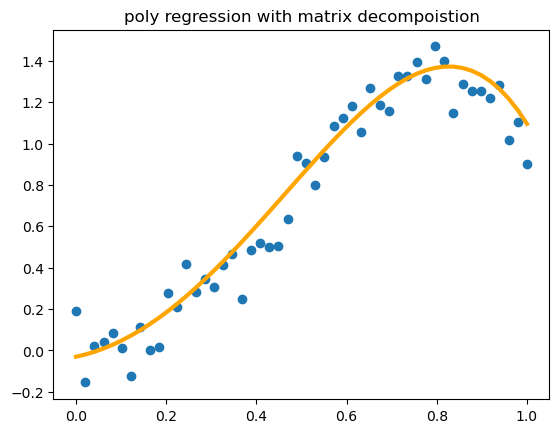

In [95]:
data_small = pd.read_csv("../data/poly_regression_small.csv")
X_small, Y_small = data_small["x"], data_small["y"]

N = X_small.shape[0]

def vandermonde(x, K):
    v = np.ones((K, N))
    for i in range(1, K):
        v[i] = x ** i
    return v

PhiX = vandermonde(X_small, K)

# solve X XT theta = X Y
L = np.linalg.cholesky(PhiX @ PhiX.T)
# solve L z = X Y
z = np.linalg.solve(L, PhiX @ Y_small)
# solve LT theta = z
theta = np.linalg.solve(L.T, z)
theta_M_s = theta

# Visualize the data
# plt.plot(X_small, Y_small, 'o')
# plt.plot(X_small, f(X_small, theta))
# plt.xlabel("x")
# plt.ylabel("y")
# plt.grid()
# plt.show()

err_M_s = (1/ len(Y_test_large)) * sum([loss(theta, x, y) for x, y in list(zip(X_test_large, Y_test_large))])

# Results
print(f"Theta: {theta}")
print(f"Relative error: {err}")

plt.scatter(X_small, Y_small)
plt.plot(X_small, f(X_small, theta_history[-1]), c="orange", linewidth=3)
plt.title("poly regression with matrix decompoistion")
plt.show()

##### Training with SGD

Theta: [-0.118503    1.65466448  0.79098844 -0.16236025 -0.88797882]
Relative error: 0.011153857365891882


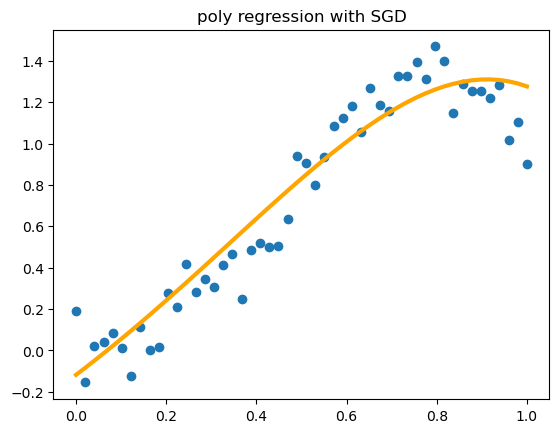

In [96]:
# Train
theta_history, loss_history, grad_norm_history = SGD(loss, grad_loss, (X_small, Y_small), theta0, alpha, batch_size, n_epochs)
err_SGD_s = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
theta_SGD_s = theta_history[-1]

# Results
print(f"Theta: {theta_history[-1]}")
print(f"Relative error: {err_SGD}")

plt.scatter(X_small, Y_small)
plt.plot(X_small, f(X_small, theta_history[-1]), c="orange", linewidth=3)
plt.title("poly regression with SGD")
plt.show()

##### Training with GD

Theta: [0.16054266 0.73063941 0.45292723 0.19212998 0.00432409]
Relative error: 0.014724625691526685


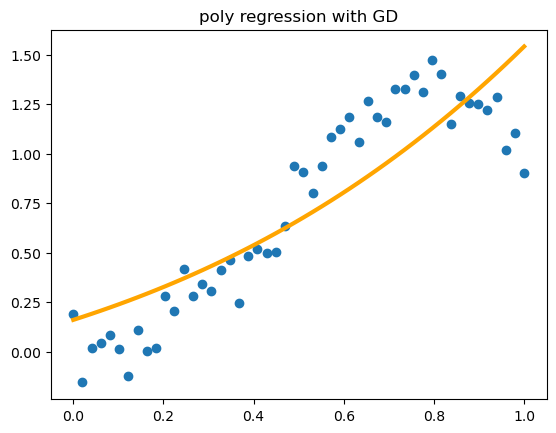

In [97]:
# Train
theta_history, loss_history, grad_norm_history = GD(loss, grad_loss, (X_small, Y_small), theta0, alpha, n_epochs)
err_GD_s = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_small, Y_small))])
theta_GD_s = theta_history[-1]

# Results
print(f"Theta: {theta_history[-1]}")
print(f"Relative error: {err_GD}")

plt.scatter(X_small, Y_small)
plt.plot(X_small, f(X_small, theta_history[-1]), c="orange", linewidth=3)
plt.title("poly regression with GD")
plt.show()

#### Results

In [106]:
theta_true = np.array([0,0,4,0,-3])
err_true = (1/ len(Y_test_large)) * sum([loss(theta_true, x, y) for x, y in list(zip(X_small, Y_small))])

print("Model \t\t Theta")
print("----------------------")
print(f"SGD large: \t {theta_SGD[0]:.3f}\t{theta_SGD[1]:.3f}\t{theta_SGD[2]:.3f}\t{theta_SGD[3]:.3f}\t{theta_SGD[4]:.3f} ")
print(f"GD large: \t {theta_GD[0]:.3f}\t{theta_GD[1]:.3f}\t{theta_GD[2]:.3f}\t{theta_GD[3]:.3f}\t{theta_GD[4]:.3f} ")
print(f"SGD small: \t {theta_SGD_s[0]:.3f}\t{theta_SGD_s[1]:.3f}\t{theta_SGD_s[2]:.3f}\t{theta_SGD_s[3]:.3f}\t{theta_SGD_s[4]:.3f} ")
print(f"GD small: \t {theta_GD_s[0]:.3f}\t{theta_GD_s[1]:.3f}\t{theta_GD_s[2]:.3f}\t{theta_GD_s[3]:.3f}\t{theta_GD_s[4]:.3f} ")
print(f"NE small: \t {theta_M_s[0]:.3f}\t{theta_M_s[1]:.3f}\t{theta_M_s[2]:.3f}\t{theta_M_s[3]:.3f}\t{theta_M_s[4]:.3f} ")
print(f"true:\t \t {theta_true[0]}\t{theta_true[1]}\t{theta_true[2]}\t{theta_true[3]}\t{theta_true[4]} ")

print(" ")
print(" ")

print("Model \t\t Relative error")
print("-------------------------------")
print(f"SGD large: \t {err_SGD:.4f}")
print(f"GD large: \t {err_GD:.4f}")
print(f"SGD small: \t {err_SGD_s:.4f}")
print(f"GD small: \t {err_GD_s:.4f}")
print(f"NE small: \t {err_M_s:.4f}")
print(f"true:\t \t {err_true:.4f}")

Model 		 Theta
----------------------
SGD large: 	 -0.031	0.466	3.039	0.541	-2.918 
GD large: 	 0.173	0.697	0.455	0.226	0.064 
SGD small: 	 -0.119	1.655	0.791	-0.162	-0.888 
GD small: 	 0.161	0.731	0.453	0.192	0.004 
NE small: 	 0.033	-0.460	4.843	0.172	-3.661 
true:	 	 0	0	4	0	-3 
 
 
Model 		 Relative error
-------------------------------
SGD large: 	 0.0112
GD large: 	 0.0147
SGD small: 	 0.0187
GD small: 	 0.0145
NE small: 	 0.0108
true:	 	 0.0025


### Varible K, Theta0 = [0, ..., 0]

In [51]:
# Load data
data_large = pd.read_csv("../data/poly_regression_large.csv")
X_large, Y_large = data_large["x"], data_large["y"]
X_train_large, X_test_large, Y_train_large, Y_test_large = train_test_split(X_large, Y_large, test_size=0.20, random_state=333, shuffle=True)
X_train_large, X_test_large, Y_train_large, Y_test_large = np.array(X_train_large), np.array(X_test_large), np.array(Y_train_large), np.array(Y_test_large)
assert X_train_large.shape[0], Y_train_large.shape[0]

data_small = pd.read_csv("../data/poly_regression_small.csv")
X_small, Y_small = data_small["x"], data_small["y"]
assert X_small.shape[0], Y_small.shape[0]

N = X_small.shape[0]
def vandermonde(x, K):
    v = np.ones((K, N))
    for i in range(1, K):
        v[i] = x ** i
    return v


batch_size = 8
n_epochs = 100
alpha = 0.1
n = 10

errs_SGD = np.zeros(n)
errs_GD = np.zeros(n)
errs_SGD_s = np.zeros(n)
errs_GD_s = np.zeros(n)
thetas_SGD = []
thetas_GD = []
thetas_SGD_s = []
thetas_GD_s = []

for i in range(1, n+1, 1):
    K = i
    theta0 = np.zeros((K,))

    theta_history, loss_history, grad_norm_history = SGD(loss, grad_loss, (X_train_large, Y_train_large), theta0, alpha, batch_size, n_epochs)
    errs_SGD[i-1] = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
    thetas_SGD.append(theta_history[-1])
    
    theta_history, loss_history, grad_norm_history = GD(loss, grad_loss, (X_train_large, Y_train_large), theta0, alpha, n_epochs)
    errs_GD[i-1] = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
    thetas_GD.append(theta_history[-1])
    
    theta_history, loss_history, grad_norm_history = SGD(loss, grad_loss, (X_small, Y_small), theta0, alpha, batch_size, n_epochs)
    errs_SGD_s[i-1] = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
    thetas_SGD_s.append(theta_history[-1])

    theta_history, loss_history, grad_norm_history = GD(loss, grad_loss, (X_small, Y_small), theta0, alpha, n_epochs)
    errs_GD_s[i-1] = (1/ len(Y_test_large)) * sum([loss(theta_history[-1], x, y) for x, y in list(zip(X_test_large, Y_test_large))])
    thetas_GD_s.append(theta_history[-1])

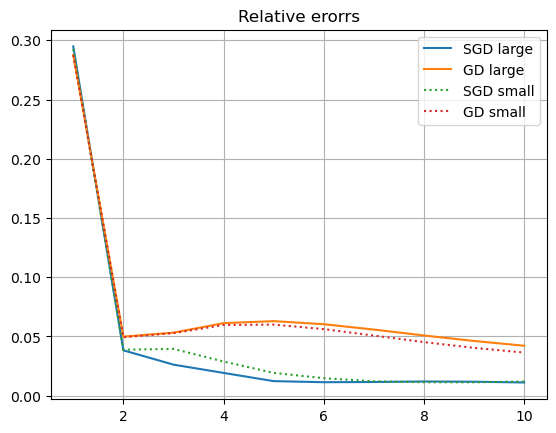

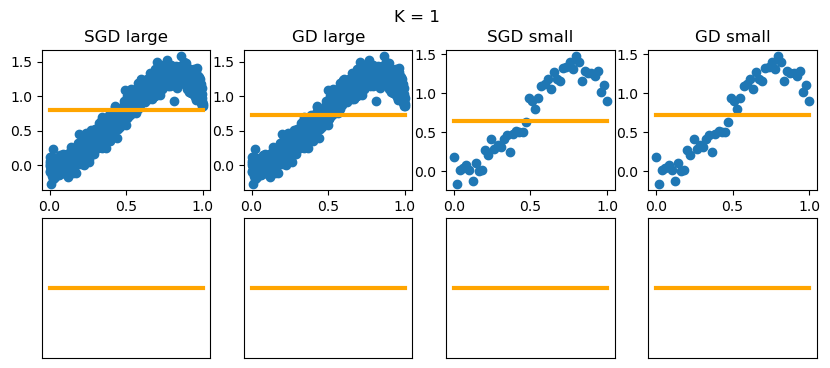

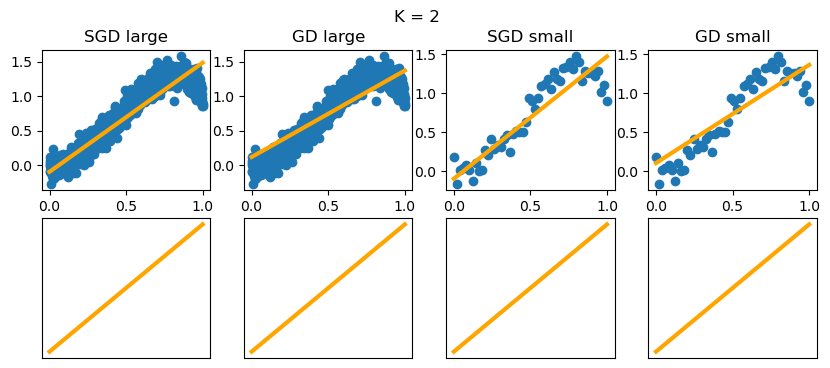

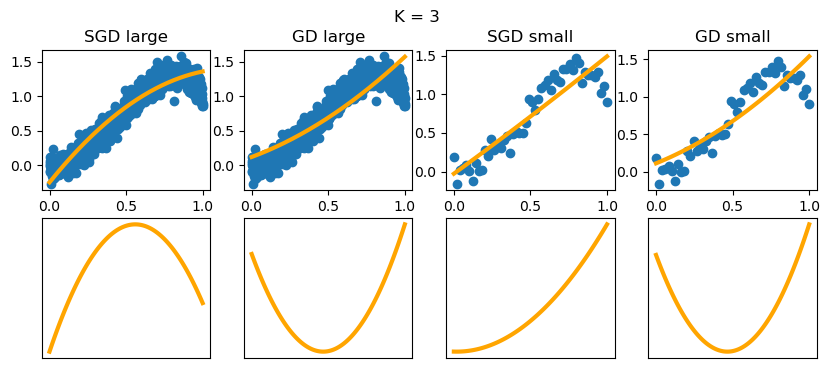

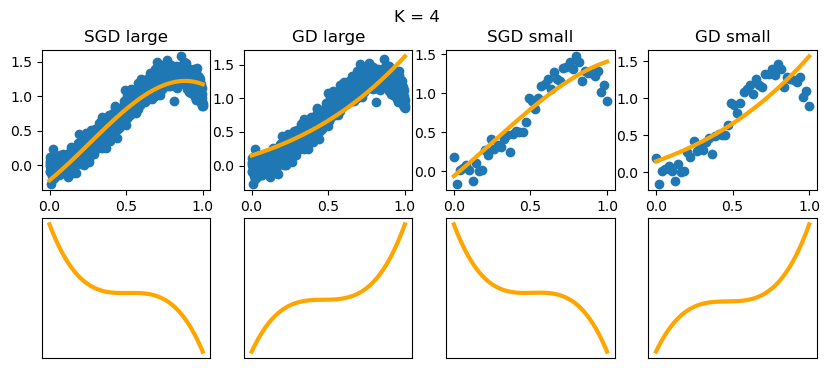

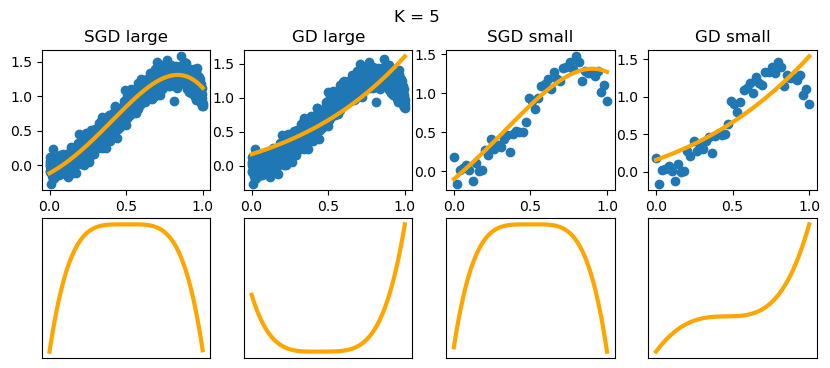

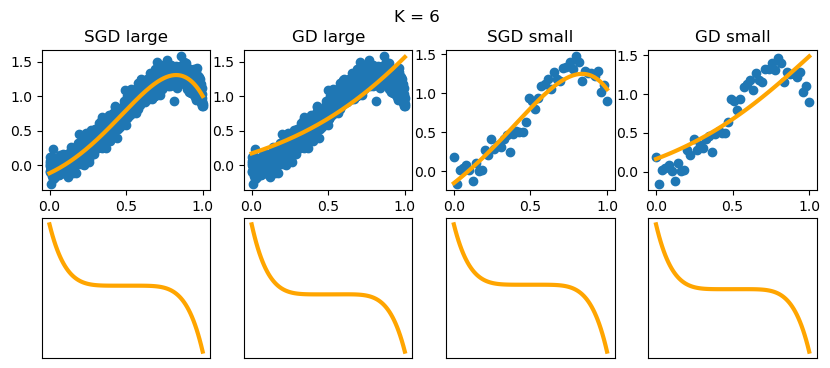

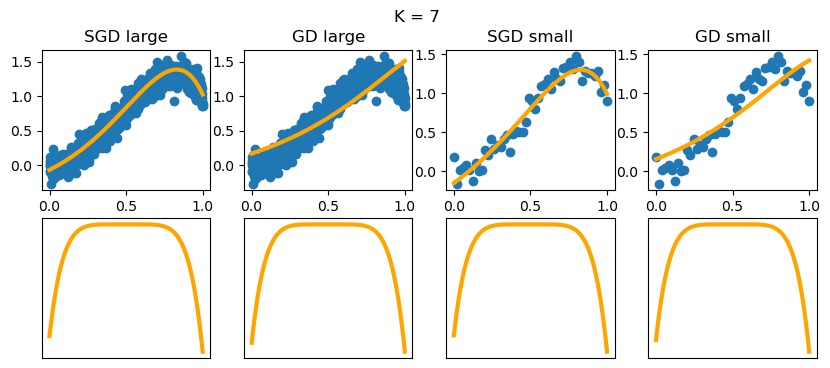

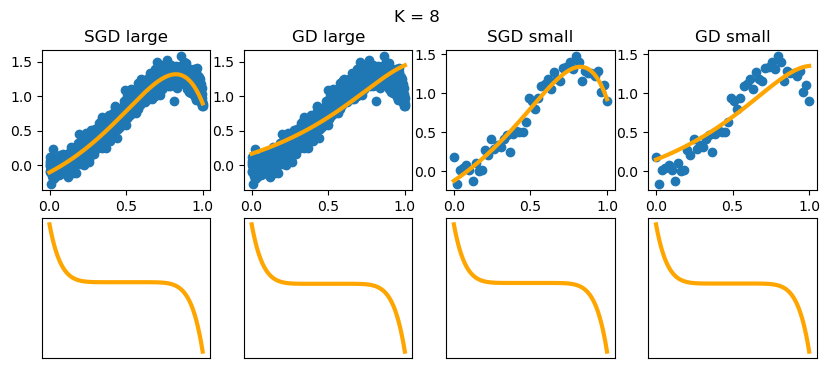

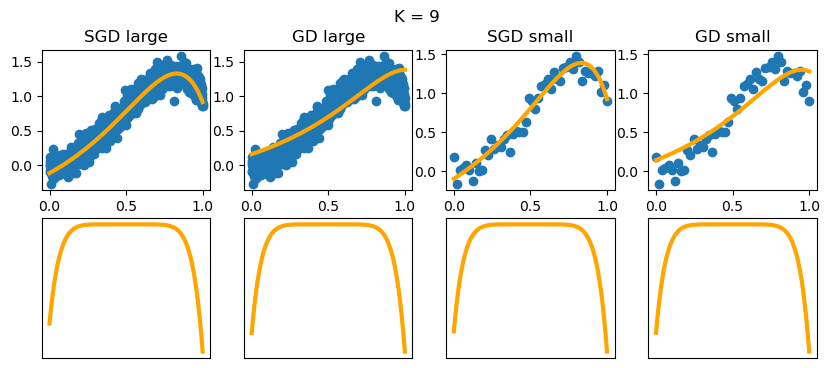

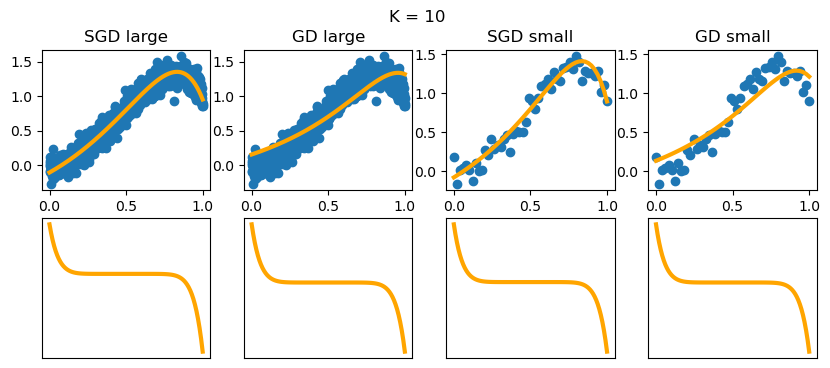

In [52]:
x = range(1,n+1)
plt.plot(x, errs_SGD, label="SGD large")
plt.plot(x, errs_GD, label="GD large")
plt.plot(x, errs_SGD_s, ':', label="SGD small")
plt.plot(x, errs_GD_s, ':', label="GD small")
plt.legend()
plt.grid()
plt.title("Relative erorrs")
plt.show()

x = np.linspace(-10, 10, 100)
for i in range(0, n, 1):
    plt.figure(figsize=(10, 4))
    plt.suptitle(f"K = {i+1}")

    plt.subplot(2,4,1)
    plt.scatter(X_large, Y_large)
    plt.plot(X_large, f(X_large, thetas_SGD[i]), c="orange", linewidth=3)
    plt.title("SGD large")
    plt.subplot(2,4,5)
    plt.plot(x, f(x, thetas_SGD[i]), c="orange", linewidth=3)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,4,2)
    plt.scatter(X_large, Y_large)
    plt.plot(X_large, f(X_large, thetas_GD[i]), c="orange", linewidth=3)
    plt.title("GD large")
    plt.subplot(2,4,6)
    plt.plot(x, f(x, thetas_GD[i]), c="orange", linewidth=3)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,4,3)
    plt.scatter(X_small, Y_small)
    plt.plot(X_small, f(X_small, thetas_SGD_s[i]), c="orange", linewidth=3)
    plt.title("SGD small")
    plt.subplot(2,4,7)
    plt.plot(x, f(x, thetas_SGD_s[i]), c="orange", linewidth=3)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2,4,4)
    plt.scatter(X_small, Y_small)
    plt.plot(X_small, f(X_small, thetas_GD_s[i]), c="orange", linewidth=3)
    plt.title("GD small")
    plt.subplot(2,4,8)
    plt.plot(x, f(x, thetas_GD_s[i]), c="orange", linewidth=3)
    plt.xticks([])
    plt.yticks([])

    plt.show()  